## Extracting and Mapping Place Names  


### Introduction

This notebook demonstrates the power of and problems with automated geoparsing. **Geoparsing** is a term used for two related tasks:
1. **[NER: named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition)**, the automatic extraction of named terms from a text documents, with the focus on place names and locations.
2. **[Geocoding](https://en.wikipedia.org/wiki/Geocoding)**, the process of determining the geographic coordinates for place names, codes and street addresses.

Why geoparse? One reason might be to determine all locations that are mentioned in a text. Another might be to determine only the most important locations, which might be indicated by how often they are mentioned or where they are mentioned, e.g., in a title or chapter heading. The output of geoparsing can be used to answer all types of questions, like 'What was the geographic evolution of the use of the term *dude*?

NER and geocoding are complex computational tasks that are beyond the scope of this notebook. Instead, this notebook aims to get you thinking about the complexity and richness of place names and the value of coordinate representations of places, both of which make geoparasing so important.


#### In this notebook we:
1. Fetch the text of the book ['Around the World in 80 Days' by Jules Verne](http://www.gutenberg.org/cache/epub/103/pg103.txt) from the [Project Gutenberg](http://www.gutenberg.org) online library.
2. Extract place name references from that text using the Python natural language processing library [SpaCy](https://spacy.io/)
3. Geocode the place names with [Geopy](https://geopy.readthedocs.io/en/1.10.0/) package and the [Nominatim](http://nominatim.org/) open source geocoder from [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap).
4. Map the named place locations with the maps module of the [datascience](https://github.com/data-8/datascience) package.

#### Learning goals:
- Think about the difference in place name vs. coordinate representations of locations.
- Experience the power and challenges of automated place name extraction.
- Consider some of the things you can do with the place names once they are geocoded.

<hr/>


# [SpaCy](https://spacy.io/): Industrial-Strength NLP

The tradtional NLP library has always been [NLTK](http://www.nltk.org/). While `NLTK` is still very useful for linguistics analysis and exporation, `SpaCy` has become a nice option for easy and fast implementation of the NLP pipeline. What's the NLP pipeline? It's a number of common steps computational linguists perform to help them (and the computer) better understand textual data. Digital Humanists are often fond of the pipeline because it gives us more things to count! (Source: Chris Hench, ....)

SpaCy is full-featured and super fast. But in this exercise we are just getting a little taste.

### Step 0. Install SpaCy if you don't have it

Uncomment and run the following cell to install SpaCy and its core English language processing tools.

In [6]:
!pip install spacy
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 1.5MB/s ta 0:00:011



    Linking successful
    /Applications/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
    /Applications/anaconda3/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



### Step 1. Load the python libraries we will use.

In [9]:
from datascience import *
import requests
from collections import Counter
import spacy
import numpy as np
import folium
#nlp = spacy.load('en')
nlp = spacy.load('en', parser=False)  # run this instead if you don't have > 1GB RAM

Let's test SpaCy to make sure it's working and see its output. the `nlp` function will parse the input text and create a model of the document that can then be used for text processing. Below is an example from the SpaCy web site.


In [10]:
# Process whole documents
text = (u"When Sebastian Thrun started working on self-driving cars at "
        u"Google in 2007, few people outside of the company took him "
        u"seriously. “I can tell you very senior CEOs of major American "
        u"car companies would shake my hand and turn away because I wasn’t "
        u"worth talking to,” said Thrun, now the co-founder and CEO of "
        u"online higher education startup Udacity, in an interview with "
        u"Recode earlier this week.")
doc_model = nlp(text)

SpaCy makes it easy to extract named entities and their [types](https://spacy.io/usage/linguistic-features#entity-types).

In [11]:
# Find named entities, phrases and concepts
for entity in doc_model.ents:
    print(entity.text, entity.label_)

Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun PERSON
Recode ORG
earlier this week DATE


The `Counter` module of the `collections` package will help us keep count of the named entities we parse.  An example of this is shown below for the text we just processed.

In [12]:
my_places = []
for ent in doc_model.ents:
    if ent.label_ == "GPE":
        my_places.append(ent.text.strip())

my_places = Counter(my_places)
my_places

Counter()

### Step 2. Fetch the text we want to geoparse

In this exercise we will geoparse the book ['Around the World in 80 Days' by Jules Verne](http://www.gutenberg.org/files/103/103.txt). You can check it out in your browser via the URL http://www.gutenberg.org/files/103/103.txt.  

We are fetching the book from the [Project Gutenberg](http://www.gutenberg.org) website, the first online provider of free electronic books, or eBooks, currently hosting over 57,000 books. 

In [13]:
## Downloaded from Project Gutenberg
text_url = "http://www.gutenberg.org/files/103/103.txt"
## Alt url if that doesn't work
#text_url = 'https://raw.githubusercontent.com/data-8/geospatial-connector/gh-pages/data/around_world_80days.txt' 

the_text = requests.get(text_url).text
the_text = the_text[4191:].replace('\r\n', ' ')  # fix formatting and skip title header

### Step 3. Process the text with SpaCy

Parse the text with `SpaCy.nlp`.

In [14]:
parsed_text = nlp(the_text)

Extract and Count the named places - those with the entity type `GPE`.

In [15]:
places = []

for ent in parsed_text.ents:
    if ent.label_ == "GPE":
        places.append(ent.text.strip())

places = Counter(places)
places


Counter({'': 22,
         '1.A.': 1,
         'Aden': 8,
         'Alabama': 2,
         'Allahabad': 5,
         'America': 14,
         'Amphion': 1,
         'Anam': 1,
         'Aouda': 134,
         'Arkansas': 1,
         'Athens': 1,
         'Aurungabad': 1,
         'Bab-el-Mandeb': 1,
         'Bah': 2,
         'Baring': 2,
         'Behar': 2,
         'Benares': 5,
         'Bengal': 2,
         'Biblical': 1,
         'Birmingham': 1,
         'Bombay': 58,
         'Boulevard': 1,
         'Brazil': 1,
         'Brindisi': 8,
         'Burdwan': 1,
         'Burglars': 1,
         'Buxar': 1,
         'Calais': 1,
         'California': 2,
         'Camerfield': 4,
         'Captain--': 1,
         'Chandernagor': 2,
         'Cheshire': 1,
         'Chicago': 7,
         'Chili': 1,
         'China': 13,
         'Chinamen': 1,
         'Cisco': 1,
         'Colfax': 1,
         'Colorado': 3,
         'Columbus': 1,
         'Consul': 2,
         'Creek': 1,
         '

Take a look at the output. What do you think? Was the processing fast? Did it extract named places?  Can you spot any errors?

You can spend a lot of time cleaning up errors in NER output. It's best to think of ways to automate that.  One simple first cut is to just keep the places with more than a minimal number of mentions. A good way to get a sense of where your cut off point display the places in descending order by count. We can save the information in a table.

In [16]:
places_table = Table(['name','count']).with_rows(places.most_common())

In [17]:
# How many places
places_table.num_rows

175

In [18]:
# Take a look at the table
places_table.show()

name,count
Aouda,134
London,64
Hong Kong,60
Bombay,58
Yokohama,39
India,35
San Francisco,29
New York,28
Liverpool,27
Omaha,24


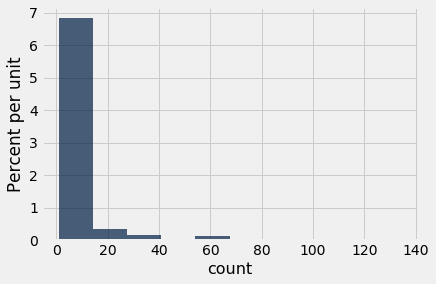

In [19]:
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
places_table.hist('count')

Let's keep the places with more than 5 mentions.

In [20]:
places5_table = places_table.where('count', are.above(5))
places5_table.num_rows

30

In [21]:

places_table.show()

name,count
Aouda,134
London,64
Hong Kong,60
Bombay,58
Yokohama,39
India,35
San Francisco,29
New York,28
Liverpool,27
Omaha,24


The list of places isn't perfect -it still contains non-places (such as?).  But let's move on to our next step as that may weed out the non-places.


### Step 3. Geocoding with Geopy and Nominatim

Geocoding is the process of determining the geographic coordinates for named places, zip codes, or street addresses. Geocoding will allow us to map these locations.

To do this we need to compare our place names with a database of places and geometric representations of these places. We will use the **geocoders** module of the **Geopy** package to do this. Geopy.geocoders provides access to several different geocoding tools, the most popular and accurate of which is the **Google Geocoding API**.  But we will use the free and easy `Nominatim` as it has few restrictions and requires no API key.

In [22]:
from geopy.geocoders import Nominatim
#import time

geolocator = Nominatim(timeout=10)

Check out syntax for and the output of geocoding one named place.

In [23]:
loc1 = geolocator.geocode("Berkeley")

In [24]:
loc1

Location(Berkeley, Alameda County, California, USA, (37.8708393, -122.2728639, 0.0))

In [25]:
loc1 #.tab

Location(Berkeley, Alameda County, California, USA, (37.8708393, -122.2728639, 0.0))

In [26]:
loc1.raw

{'boundingbox': ['37.835727', '37.9066896', '-122.3686793', '-122.2341962'],
 'class': 'place',
 'display_name': 'Berkeley, Alameda County, California, USA',
 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png',
 'importance': 0.695505117607742,
 'lat': '37.8708393',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '-122.2728639',
 'osm_id': '2833528',
 'osm_type': 'relation',
 'place_id': '198436583',
 'type': 'city'}

Now try a non-US place name, one that is no longer used.

In [27]:
loc2 = geolocator.geocode("Bombay")

In [28]:
loc2

Location(Mumbai, Mumbai City, Maharashtra, India, (18.9387711, 72.8353355, 0.0))

## Challenge

In the cell below write print statements to display the following for `loc2`.

- place name for display
- latitude
- longitude
- place type

In [29]:
# YOUR CODE HERE

Let's geocode our places5_table to get the latitude, longitude, and place type of each location.

In [30]:
for i in range(0, places5_table.num_rows):
    print(places5_table.column('name').item(i))

Aouda
London
Hong Kong
Bombay
Yokohama
India
San Francisco
New York
Liverpool
Omaha

England
Mongolia
Tankadere
Fogg
Shanghai
America
the United States
China
Singapore
Japan
Sioux
Paris
Pillaji
Brindisi
Aden
Sacramento
Chicago
Kiouni
Utah


In [31]:
# Define our output table structure
#geo_tab = Table(["latitude", "longitude", "name_in_text", "full_name","num_mentions", "place_type"])
geo_tab = Table(["name_in_text","num_mentions"])

#for name in places.keys():  # only want to loop through unique place names to call once per place name
for i in range (0, 4):
    name =  places5_table.column('name').item(i)
    count = places5_table.column('count').item(i)
    
    geo_tab.append([name, count])

geo_tab.show()

name_in_text,num_mentions
Aouda,134
London,64
Hong Kong,60
Bombay,58


In [32]:
# Define our output table structure
geo_tab = Table(["latitude", "longitude", "name_in_text", "full_name","num_mentions", "place_type"])

for i in range (0, places5_table.num_rows):
    name =  places5_table.column('name').item(i)
    num_mentions = places5_table.column('count').item(i)
    
    print("Geocoding " + name + "..." + " with " + str(num_mentions) + " counts....")
    
    # finds the lat and lon for this name
    location = geolocator.geocode(name)
    
    try:
        # index the raw response for lat and lon
        lat = float(location.raw["lat"])
        lon = float(location.raw["lon"])
        full_name = location.raw['display_name']
        place_type = location.raw['type']
 
        # add to output table
        geo_tab.append([lat , lon , name, full_name, num_mentions, place_type])
    
    except:
        pass

Geocoding Aouda... with 134 counts....
Geocoding London... with 64 counts....
Geocoding Hong Kong... with 60 counts....
Geocoding Bombay... with 58 counts....
Geocoding Yokohama... with 39 counts....
Geocoding India... with 35 counts....
Geocoding San Francisco... with 29 counts....
Geocoding New York... with 28 counts....
Geocoding Liverpool... with 27 counts....
Geocoding Omaha... with 24 counts....
Geocoding ... with 22 counts....
Geocoding England... with 20 counts....
Geocoding Mongolia... with 20 counts....
Geocoding Tankadere... with 18 counts....
Geocoding Fogg... with 17 counts....
Geocoding Shanghai... with 17 counts....
Geocoding America... with 14 counts....
Geocoding the United States... with 14 counts....
Geocoding China... with 13 counts....
Geocoding Singapore... with 12 counts....
Geocoding Japan... with 12 counts....
Geocoding Sioux... with 12 counts....
Geocoding Paris... with 11 counts....
Geocoding Pillaji... with 9 counts....
Geocoding Brindisi... with 8 counts...

In [41]:
geo_tab.sort('longitude', descending=False).show()

latitude,longitude,name_in_text,full_name,num_mentions,place_type
37.7793,-122.419,San Francisco,"SF, California, USA",29,city
38.5816,-121.494,Sacramento,"Sacramento, Sacramento County, California, USA",7,city
39.4225,-111.714,Utah,"Utah, USA",6,administrative
39.7837,-100.446,the United States,USA,14,administrative
43.0574,-96.1602,Sioux,"Sioux County, Iowa, USA",12,administrative
41.2587,-95.9379,Omaha,"Omaha, Douglas County, Nebraska, USA",24,city
31.1774,-94.7866,Fogg,"Fogg, Diboll, Angelina County, Texas, 75941, USA",17,residential
41.8756,-87.6244,Chicago,"Chicago, Cook County, Illinois, USA",7,city
4.81805,-75.6889,America,"America, Río Otún, Perimetro Urbano Pereira, Pereira, Ri ...",14,administrative
40.7309,-73.9872,New York,"NYC, New York, USA",28,city


Now that the places are geocoded we can create an interactive map of the locations using the  `folium` Python library. 

datascience.tables.Table

In [36]:
my_map = folium.Map(location=(np.mean(geo_tab['latitude']), np.mean(geo_tab['longitude'])), zoom_start=2)
display(my_map)

In [88]:
my_map = folium.Map(location=(np.mean(geo_tab['latitude']), np.mean(geo_tab['longitude'])), zoom_start=2)

for latitude, longitude,name, num_mentions in geo_tab.select(['latitude','longitude','name_in_text', 'num_mentions']).rows:
    folium.Marker(
            location=[latitude, longitude],
            popup=folium.Popup(
                            folium.IFrame(
                                html= name + " (" + str(num_mentions) + ")",
                                width=150,
                                height=40),
                                max_width=2650
                            )
            ).add_to(my_map)

display(my_map)

We can make fancier maps by using data values to drive the symbology. See the documentation for `folium.CircleMarker`, for example.

In [108]:
#folium.Circle?

In [114]:
my_map = folium.Map(location=(np.mean(geo_tab['latitude']), np.mean(geo_tab['longitude'])), zoom_start=2)

for latitude, longitude,name, num_mentions in geo_tab.select(['latitude','longitude','name_in_text', 'num_mentions']).rows:
    folium.CircleMarker(
        location=[latitude, longitude],
        fill=True,
        fill_color="red",
        radius = num_mentions.astype(float)/2,
        #radius = pow(10,num_mentions.astype(float)), #num_mentions.astype(float) + 1) * 100000,
        popup=folium.Popup(
            folium.IFrame(
                html= name + " (" + str(num_mentions) + ")",
                width=150,
                height=40),
                max_width=2650
                )
            ).add_to(my_map)

display(my_map)

### Evaluate our work

How well did this process work in identifying the locations visited by the characters in `Around the World in 80 Days`?

>"These dates were inscribed in an itinerary divided into columns,
indicating the month, the day of the month, and the day for the
stipulated and actual arrivals at each principal point Paris, Brindisi,
Suez, Bombay, Calcutta, Singapore, Hong Kong, Yokohama, San Francisco,
New York, and London--from the 2nd of October to the 21st of December;"

Add the actual route map is...
<img src="http://kickasstrips.com/wp-content/uploads/2014/06/Around_the_World_in_Eighty_Days_map_Jules_Verne.jpg" width="800"></img>

See: (http://kickasstrips.com/2014/06/around-the-world-in-80-days-phileas-foggs-original-journey/)

### Discussion

1. Are there places that you would like to remove from the table? If yes, why?
2. Name some of the reasons why place name geoparsing is difficult.
3. Why is place name "data cleaning" difficult.  
4. Why might we remove the places "Fogg", "Passepartout" and 'Aouda'. Take a look at the ebook URL for clues.
5. Can you guess what types of documents would geoparse better than others? worse?
6. What are the alternatives to automated geoparsing?
7. Discuss some of the pros & cons of referencing that big city across the bay as 'San Francisco' vs. '37.77493, -122.41942'.

<hr>
Created by `pattyf@berkeley.edu`. Last updated November 2018.